# Titanic Survival Prediction (DATA103 - Group 5)

**Problem statement.** Predict whether a passenger survived the Titanic disaster using demographic and ticket information, framing it as a **binary classification** task to support **fairer allocation and risk assessment** in maritime safety case studies.

**Why this matters.** Beyond a historical case, the pipeline mirrors real-world safety analytics: fair triage policies, risk communication, and scenario testing. We will emphasize transparency (interpretable baselines) and robustness (tree models for non-linear effects).

## Dataset & Features
We'll use the classic **Kaggle Titanic** dataset. Expected files:
- `train.csv` (with `Survived` target)
- `test.csv`

**Features in scope**
- Numeric: `Age`, `Fare`, `SibSp`, `Parch`
- Categorical: `Sex`, `Pclass` (treated as categorical), `Embarked`
- Text/sparse: `Name` (to engineer `Title`), `Ticket` (prefix/bucket), `Cabin` (deck / missingness flag)

**Engineered features (Phase 1 plan)**
- `Title` from `Name`
- `FamilySize = SibSp + Parch + 1`
- `IsAlone = 1 if FamilySize == 1 else 0`
- `FarePerPerson = Fare / FamilySize`
- `CabinDeck = first letter of Cabin` (with `Unknown` for missing)
- `TicketPrefix = non-digit prefix` (bucketed; `None` for purely numeric)

We'll also **impute**: `Age` (median within `Title`×`Pclass`), `Embarked` (mode), `Fare` (median); and optionally **bin** `Age` for tree models.

In [10]:
# Setup
import os, re, math, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
warnings.filterwarnings("ignore")

# Display options
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 42

kaggle_path = "/kaggle/input/titanic"

if os.path.exists(kaggle_path):
    TRAIN_PATH = os.path.join(kaggle_path, "train.csv")
    TEST_PATH  = os.path.join(kaggle_path, "test.csv")

if TRAIN_PATH is None:
    raise FileNotFoundError(
        "Could not find train.csv. Place Titanic CSVs in the working directory or /mnt/data/."
    )

df = pd.read_csv(TRAIN_PATH)
print("Loaded shape:", df.shape)
df.head()

Loaded shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Cleaning & Feature Engineering
Steps:
1. Standardize column names.
2. Extract `Title` from `Name` and consolidate rare titles.
3. Create `FamilySize`, `IsAlone`, `FarePerPerson`.
4. Derive `CabinDeck` and `CabinKnown`.
5. Derive `TicketPrefix` (non-digit prefix) to tame high-cardinality.
6. Impute `Embarked` (mode), `Fare` (median), and `Age` (median within `Title`×`Pclass` groups).

In [ ]:
# 1) Standardize column names
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# 2) Title extraction from Name
def extract_title(name):
    m = re.search(r",\s*([^\.]+)\.", str(name))
    return m.group(1).strip() if m else "Unknown"

df["Title"] = df["Name"].apply(extract_title)
# Consolidate rare titles
title_map = {
    "Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs",
    "Lady": "Noble", "Countess": "Noble", "Sir": "Noble", "Don": "Noble", "Dona": "Noble", "Jonkheer": "Noble",
    "Capt": "Officer", "Col": "Officer", "Major": "Officer", "Dr": "Officer", "Rev": "Officer"
}
df["Title"] = df["Title"].replace(title_map)
rare_titles = [t for t, cnt in Counter(df["Title"]).items() if cnt < 10]
df["Title"] = df["Title"].apply(lambda x: "Rare" if x in rare_titles else x)

# 3) Family features
df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)
df["Fare"] = df["Fare"].fillna(df["Fare"].median())
df["FarePerPerson"] = df["Fare"] / df["FamilySize"].replace(0, 1)

# 4) Cabin features
def get_deck(cabin):
    if pd.isna(cabin):
        return "Unknown"
    return str(cabin)[0]

df["CabinDeck"] = df["Cabin"].apply(get_deck)
df["CabinKnown"] = (~df["Cabin"].isna()).astype(int)

# 5) Ticket prefix (non-digit prefix)
def get_ticket_prefix(ticket):
    s = str(ticket).strip()
    # remove dots and slashes/spaces, then split
    s = s.replace(".", "").replace("/", " ").replace("\\", " ")
    parts = [p for p in s.split() if not p.isdigit()]
    if len(parts) == 0:
        return "NONE"
    # Normalize to first non-digit token
    return parts[0].upper()

df["TicketPrefix"] = df["Ticket"].apply(get_ticket_prefix)

# 6) Imputations
# Embarked: mode
embarked_mode = df["Embarked"].mode(dropna=True)[0] if df["Embarked"].notna().any() else "S"
df["Embarked"] = df["Embarked"].fillna(embarked_mode)

# Age: median within Title x Pclass
age_group_median = df.groupby(["Title", "Pclass"])["Age"].median()
def impute_age(row):
    if pd.isna(row["Age"]):
        return age_group_median.loc[(row["Title"], row["Pclass"])]
    return row["Age"]
df["Age"] = df.apply(impute_age, axis=1)

# Age bins for trees/EDA
age_bins = [0, 12, 18, 25, 35, 45, 60, 120]
age_labels = ["0-12", "13-18", "19-25", "26-35", "36-45", "46-60", "60+"]
df["AgeBin"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, include_lowest=True)

print("After FE:", df.shape)
df.head()

After FE: (891, 20)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,FarePerPerson,CabinDeck,CabinKnown,TicketPrefix,AgeBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,2,0,3.62500,Unknown,0,A,19-25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,0,35.64165,C,1,PC,36-45
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,1,7.92500,Unknown,0,STON,26-35
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,0,26.55000,C,1,NONE,26-35
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,1,8.05000,Unknown,0,NONE,26-35


## Exploratory Data Analysis
- Histograms/boxplots for **Age** and **Fare**; and **log(Fare)** if skewed
- Bar charts: survival rate by **Sex**, **Pclass**, **Embarked**, and **Title**
- Correlation heatmap (numeric features vs `Survived`)

Saved: figures/age_hist.png


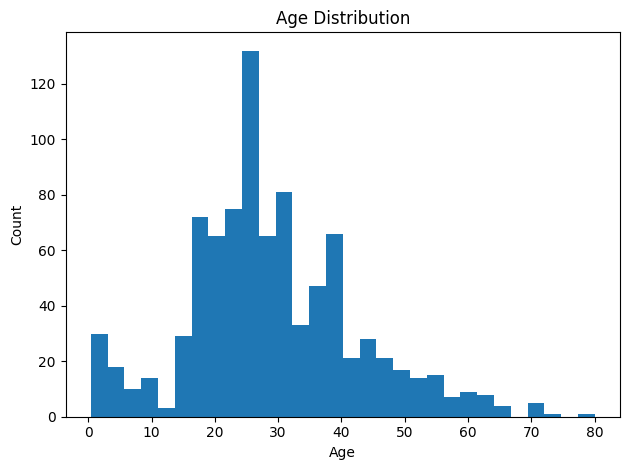

Saved: figures/age_box_by_survival.png


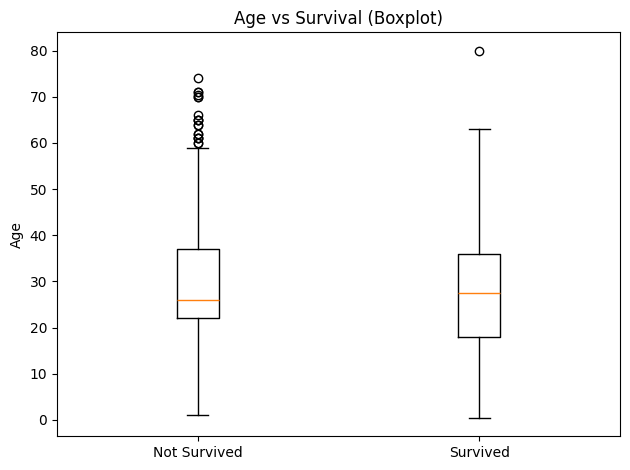

Saved: figures/fare_hist.png


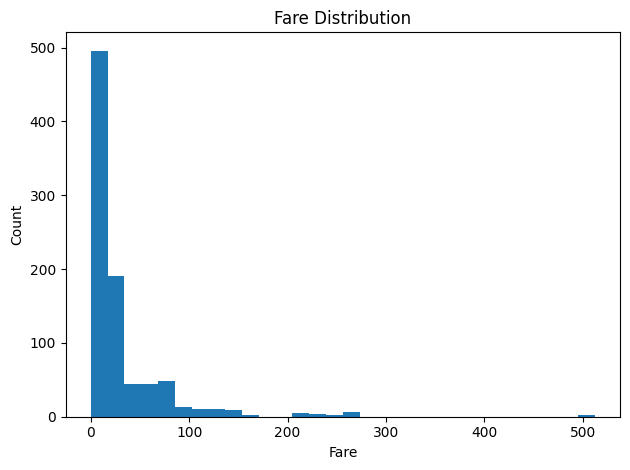

Saved: figures/log_fare_hist.png


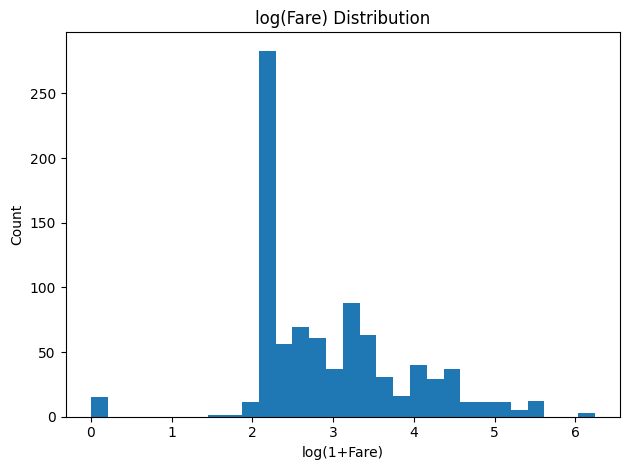

Saved: figures/survival_by_sex.png


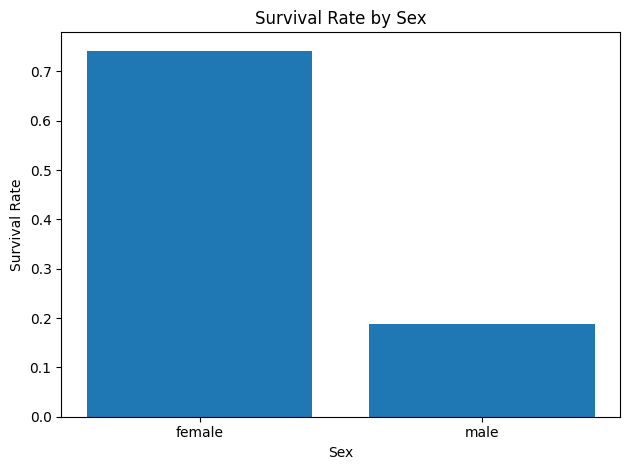

Saved: figures/survival_by_pclass.png


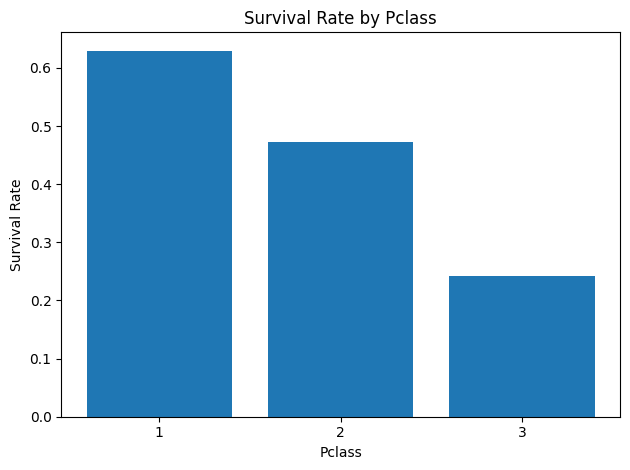

Saved: figures/survival_by_embarked.png


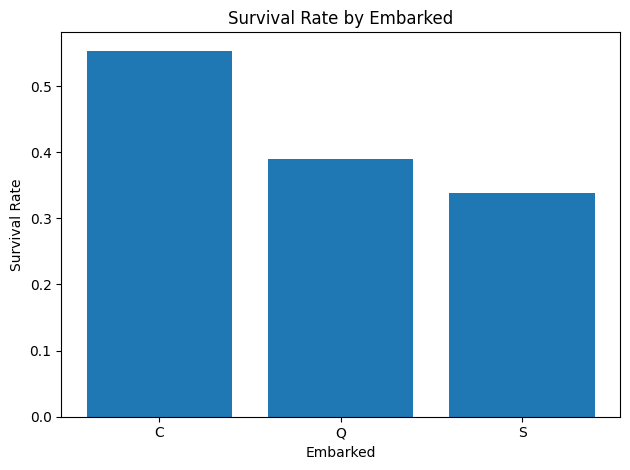

Saved: figures/survival_by_title.png


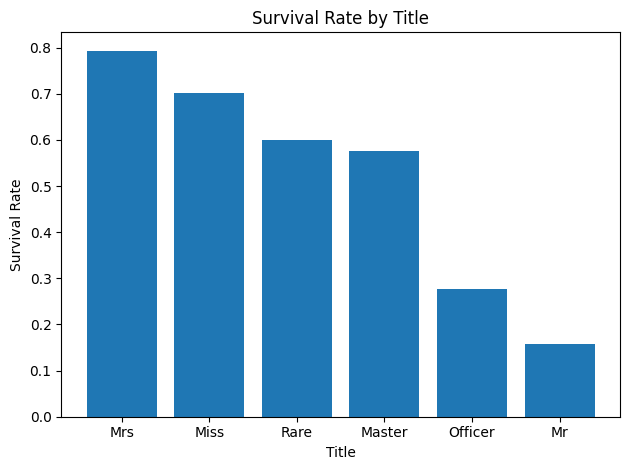

Saved: figures/corr_heatmap.png


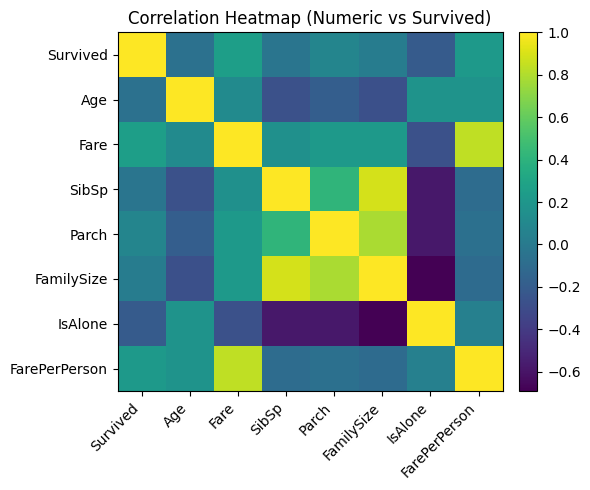

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

os.makedirs("figures", exist_ok=True)

# Helper: save figure utility
def savefig(name):
    path = os.path.join("figures", name)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=150)
    print("Saved:", path)

# 1) Age distribution
plt.figure()
plt.hist(df["Age"].dropna(), bins=30)
plt.title("Age Distribution")
plt.xlabel("Age"); plt.ylabel("Count")
savefig("age_hist.png"); plt.show()

# Boxplot Age by Survived
plt.figure()
data0 = df.loc[df["Survived"]==0, "Age"].dropna()
data1 = df.loc[df["Survived"]==1, "Age"].dropna()
plt.boxplot([data0, data1], labels=["Not Survived", "Survived"])
plt.title("Age vs Survival (Boxplot)")
plt.ylabel("Age")
savefig("age_box_by_survival.png"); plt.show()

# 2) Fare distribution & log(Fare)
plt.figure()
plt.hist(df["Fare"].dropna(), bins=30)
plt.title("Fare Distribution")
plt.xlabel("Fare"); plt.ylabel("Count")
savefig("fare_hist.png"); plt.show()

# Log Fare
log_fare = np.log1p(df["Fare"].clip(lower=0))
plt.figure()
plt.hist(log_fare, bins=30)
plt.title("log(Fare) Distribution")
plt.xlabel("log(1+Fare)"); plt.ylabel("Count")
savefig("log_fare_hist.png"); plt.show()

# 3) Survival rate bar charts
def survival_rate_bar(feature, fname):
    rates = df.groupby(feature)["Survived"].mean().sort_values(ascending=False)
    plt.figure()
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Survival Rate by {feature}")
    plt.xlabel(feature); plt.ylabel("Survival Rate")
    savefig(fname); plt.show()

survival_rate_bar("Sex", "survival_by_sex.png")
survival_rate_bar("Pclass", "survival_by_pclass.png")
survival_rate_bar("Embarked", "survival_by_embarked.png")
survival_rate_bar("Title", "survival_by_title.png")

# 4) Correlation heatmap (numeric vs Survived)
numeric_cols = ["Survived","Age","Fare","SibSp","Parch","FamilySize","IsAlone","FarePerPerson"]
corr = df[numeric_cols].corr()
plt.figure(figsize=(6,5))
# Simple heatmap using imshow (no seaborn per instructions)
im = plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Correlation Heatmap (Numeric vs Survived)")
savefig("corr_heatmap.png"); plt.show()

## Modeling Plan
- **Task:** Binary classification (`Survived`)
- **Baselines:** Majority class; Logistic Regression (after encoding, scaling numerics)
- **Tree-based:** Decision Tree, Random Forest (capture interactions such as `Sex × Pclass × Age`)
- **Validation:** Stratified train/validation split and Stratified 5-fold CV
- **Metrics:** Accuracy, Precision/Recall (macro), ROC-AUC; plus ROC curves

In [ ]:
import numpy as np
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, classification_report)

target = "Survived"

# Define feature sets
categorical = ["Sex", "Pclass", "Embarked", "Title", "CabinDeck", "TicketPrefix", "AgeBin"]
numeric = ["Age", "Fare", "SibSp", "Parch", "FamilySize", "IsAlone", "FarePerPerson", "CabinKnown"]

X = df[categorical + numeric].copy()
y = df[target].astype(int).copy()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

scaler = StandardScaler()

# For logistic regression: scale numerics, OHE categoricals
preproc_logit = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical),
        ("num", scaler, numeric),
    ]
)

# For trees: OHE categoricals, pass-through numerics
preproc_tree = ColumnTransformer(
    transformers=[
        ("cat", ohe, categorical),
        ("num", "passthrough", numeric),
    ]
)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Majority baseline
majority = y_train.mode()[0]
y_pred_majority = np.full(y_val.shape, majority, dtype=int)
print("Majority baseline accuracy:", accuracy_score(y_val, y_pred_majority))

# Logistic Regression (optionally add class_weight='balanced')
clf_logit = Pipeline(steps=[
    ("pre", preproc_logit),
    ("model", LogisticRegression(max_iter=1000, C=1.0, random_state=RANDOM_STATE))  # , class_weight="balanced"
])
clf_logit.fit(X_train, y_train)
pred_logit = clf_logit.predict(X_val)
proba_logit = clf_logit.predict_proba(X_val)[:, 1]

# Decision Tree
clf_tree = Pipeline(steps=[
    ("pre", preproc_tree),
    ("model", DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE))
])
clf_tree.fit(X_train, y_train)
pred_tree = clf_tree.predict(X_val)
proba_tree = clf_tree.predict_proba(X_val)[:, 1]

# Random Forest
clf_rf = Pipeline(steps=[
    ("pre", preproc_tree),
    ("model", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2, random_state=RANDOM_STATE))
])
clf_rf.fit(X_train, y_train)
pred_rf = clf_rf.predict(X_val)
proba_rf = clf_rf.predict_proba(X_val)[:, 1]

# Metrics helper
def eval_metrics(y_true, y_pred, y_proba, label):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    auc  = roc_auc_score(y_true, y_proba)
    print(f"\n[{label}] Accuracy={acc:.3f}  Precision={prec:.3f}  Recall={rec:.3f}  ROC-AUC={auc:.3f}")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

eval_metrics(y_val, pred_logit, proba_logit, "Logistic")
eval_metrics(y_val, pred_tree, proba_tree, "DecisionTree")
eval_metrics(y_val, pred_rf, proba_rf, "RandomForest")

# Stratified 5-fold ROC-AUC via CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, model in [("Logistic", clf_logit), ("DecisionTree", clf_tree), ("RandomForest", clf_rf)]:
    scores = cross_val_score(model, X, y, scoring="roc_auc", cv=skf)
    print(f"{name} 5-fold ROC-AUC: mean={scores.mean():.3f}  std={scores.std():.3f}")


Majority baseline accuracy: 0.6145251396648045

[Logistic] Accuracy=0.844  Precision=0.815  Recall=0.768  ROC-AUC=0.875
              precision    recall  f1-score   support

           0      0.860     0.891     0.875       110
           1      0.815     0.768     0.791        69

    accuracy                          0.844       179
   macro avg      0.838     0.830     0.833       179
weighted avg      0.843     0.844     0.843       179


[DecisionTree] Accuracy=0.788  Precision=0.738  Recall=0.696  ROC-AUC=0.831
              precision    recall  f1-score   support

           0      0.816     0.845     0.830       110
           1      0.738     0.696     0.716        69

    accuracy                          0.788       179
   macro avg      0.777     0.771     0.773       179
weighted avg      0.786     0.788     0.786       179


[RandomForest] Accuracy=0.799  Precision=0.770  Recall=0.681  ROC-AUC=0.861
              precision    recall  f1-score   support

           0     

Saved: figures/roc_curves.png


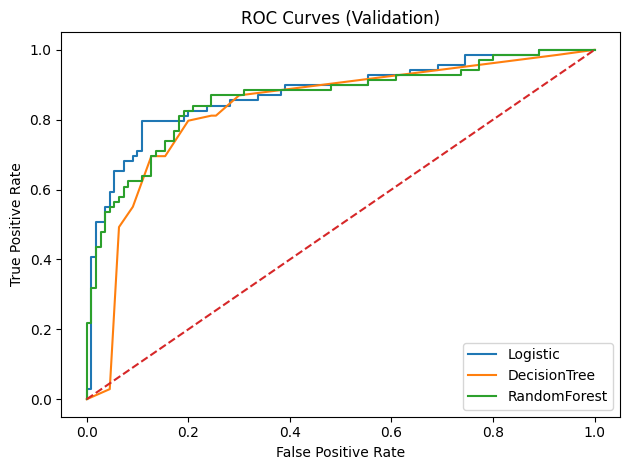

Saved: figures/rf_feature_importances.png


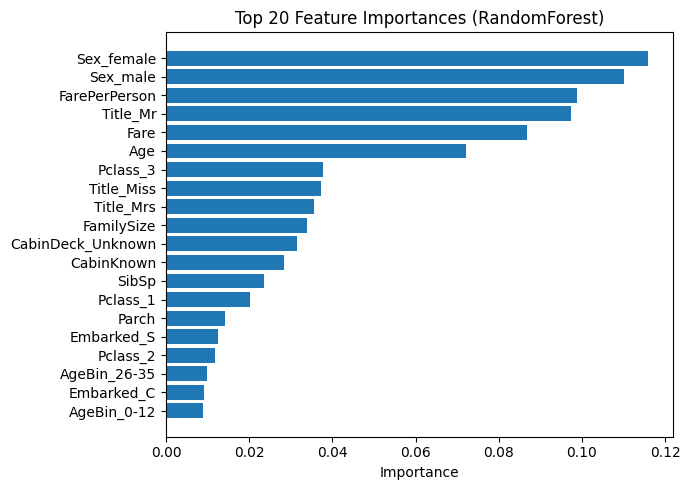

Saved: figures/logit_top_pos_coefs.png


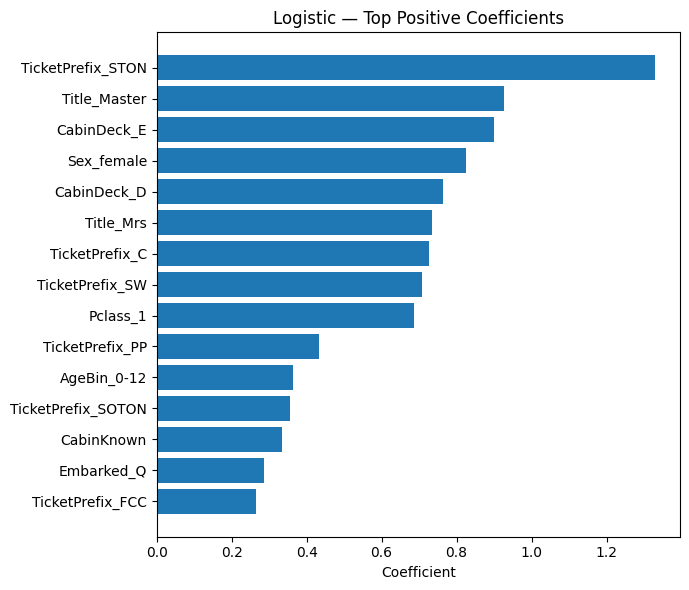

Saved: figures/logit_top_neg_coefs.png


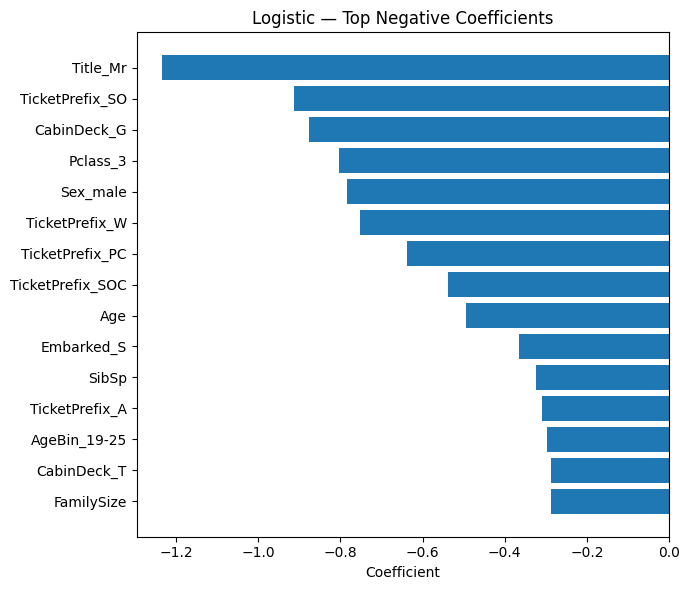

In [ ]:
# ROC curves
plt.figure()
for label, y_proba in [("Logistic", proba_logit), ("DecisionTree", proba_tree), ("RandomForest", proba_rf)]:
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=label)
# Chance line
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Validation)")
plt.legend()
savefig("roc_curves.png"); plt.show()

# Feature importances: RF
ct = clf_rf.named_steps["pre"]
model_rf = clf_rf.named_steps["model"]

# Categorical feature names from the fitted OneHotEncoder
cat_in = list(ct.transformers_[0][2])  # original categorical columns
ohe_rf = ct.named_transformers_["cat"]

# get_feature_names_out is available on newer sklearn; fallback to get_feature_names for older ones
if hasattr(ohe_rf, "get_feature_names_out"):
    cat_features = list(ohe_rf.get_feature_names_out(cat_in))
else:  # very old sklearn
    cat_features = list(ohe_rf.get_feature_names(cat_in))

# Numeric passthrough names are as given in the ColumnTransformer
num_features = list(ct.transformers_[1][2])

all_features = cat_features + num_features

importances = model_rf.feature_importances_
order = np.argsort(importances)[::-1][:20]  # top 20
plt.figure(figsize=(7, 5))
plt.barh([all_features[i] for i in order][::-1], importances[order][::-1])
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
savefig("rf_feature_importances.png"); plt.show()

# Logistic coefficients (top +/- features)
model_logit = clf_logit.named_steps["model"]
ct_logit = clf_logit.named_steps["pre"]
ohe_log = ct_logit.named_transformers_["cat"]
cat_in_log = list(ct_logit.transformers_[0][2])

if hasattr(ohe_log, "get_feature_names_out"):
    cat_features_log = list(ohe_log.get_feature_names_out(cat_in_log))
else:
    cat_features_log = list(ohe_log.get_feature_names(cat_in_log))

num_features_log = list(ct_logit.transformers_[1][2])
all_features_log = cat_features_log + num_features_log

coefs = model_logit.coef_.ravel()

# top positive / negative
top_k = 15
order_pos = np.argsort(coefs)[-top_k:][::-1]
order_neg = np.argsort(coefs)[:top_k]

plt.figure(figsize=(7, 6))
plt.barh([all_features_log[i] for i in order_pos][::-1], coefs[order_pos][::-1])
plt.title("Logistic — Top Positive Coefficients")
plt.xlabel("Coefficient")
savefig("logit_top_pos_coefs.png"); plt.show()

plt.figure(figsize=(7, 6))
plt.barh([all_features_log[i] for i in order_neg][::-1], coefs[order_neg][::-1])
plt.title("Logistic — Top Negative Coefficients")
plt.xlabel("Coefficient")
savefig("logit_top_neg_coefs.png"); plt.show()